# 🔍 Notebook 04 — SHAP Explainability Analysis

Global and local model explanations using SHAP values. Produce business-ready
feature importance reports and per-instance explanations for stakeholders.

This notebook demonstrates: extracting SHAP values, summary plots,
dependence plots, and example-level explanations for top predictions.

In [11]:
# === CELL 1: Setup ===
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 120

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"
MODELS_DIR = PROJECT_ROOT / "models" / "production"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Setup complete")

✅ Setup complete


In [2]:
# === CELL 2: Load Model and Data ===
from src.data.ingest import load_raw_data
from src.data.clean import clean_pipeline
from src.data.split import stratified_split
from src.features.build_features import TARGET

df = load_raw_data()
df = clean_pipeline(df, production=True)
df_train, df_val, df_test = stratified_split(df)

X_test = df_test.drop(columns=[TARGET])
y_test = df_test[TARGET]

# Load best model
pipeline = joblib.load(MODELS_DIR / "xgboost.joblib")
print(f"✅ Model loaded: {MODELS_DIR / 'xgboost.joblib'}")
print(f"Test set: {X_test.shape}")

✅ Model loaded: c:\Users\ashranj\GIT\DSI\DSI-Cohort8-ML-2\models\production\xgboost.joblib
Test set: (6179, 19)


In [3]:
# === CELL 3: Extract Transformed Features ===
from sklearn.pipeline import Pipeline as SkPipeline

# Get preprocessor steps (everything except the classifier)
preprocessor_pipe = SkPipeline(pipeline.steps[:-1])
classifier = pipeline.named_steps["classifier"]

# Transform test data
X_test_transformed = preprocessor_pipe.transform(X_test)

# Get feature names
try:
    feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
    feature_names = [str(f) for f in feature_names]
except Exception:
    feature_names = [f"feature_{i}" for i in range(X_test_transformed.shape[1])]

X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)
print(f"Transformed features: {X_test_df.shape[1]}")
print(f"Sample feature names: {feature_names[:10]}")

Transformed features: 49
Sample feature names: ['num__age', 'num__campaign', 'num__previous', 'num__emp.var.rate', 'num__cons.price.idx', 'num__cons.conf.idx', 'num__euribor3m', 'num__nr.employed', 'num__was_previously_contacted', 'num__pdays_log']


In [4]:
# === CELL 4: Compute SHAP Values ===
print("Computing SHAP values (TreeExplainer)...")
explainer = shap.TreeExplainer(classifier)

# Use a sample for visualization (full dataset for global, subset for speed)
SAMPLE_SIZE = min(1000, len(X_test_df))
X_sample = X_test_df.iloc[:SAMPLE_SIZE]
y_sample = y_test.iloc[:SAMPLE_SIZE]

shap_values = explainer(X_sample)
print(f"✅ SHAP values computed for {SAMPLE_SIZE} samples")
print(f"Shape: {shap_values.values.shape}")

Computing SHAP values (TreeExplainer)...
✅ SHAP values computed for 1000 samples
Shape: (1000, 49)


GLOBAL FEATURE IMPORTANCE — SHAP Beeswarm


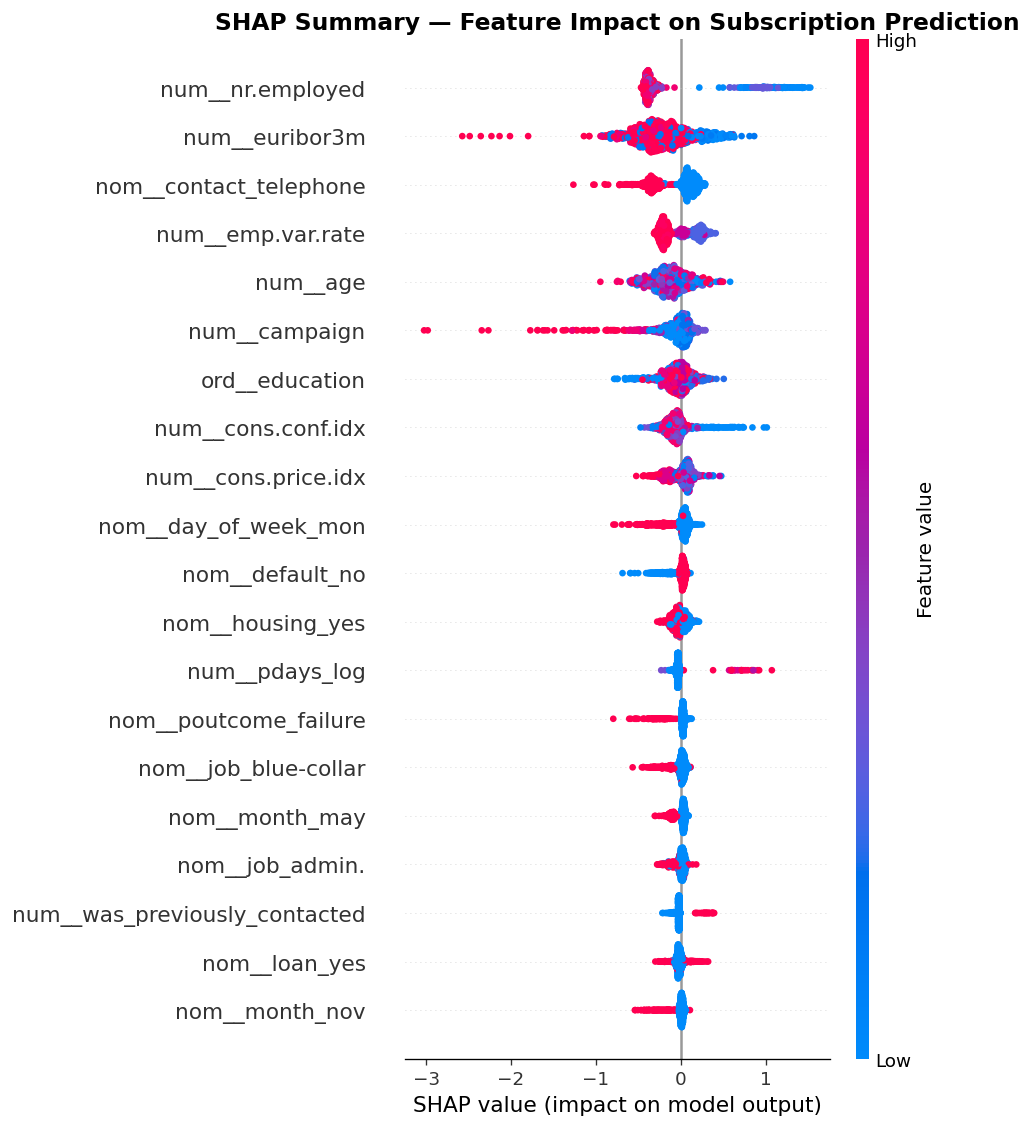

📋 HOW TO READ THIS PLOT:
  • Each dot = one prediction
  • X-axis = SHAP value (impact on model output)
  • Color = feature value (red=high, blue=low)
  • Positive SHAP = pushes prediction toward 'subscribe'
  • Negative SHAP = pushes prediction toward 'not subscribe'


In [5]:
# === CELL 5: Global SHAP Summary Plot (Beeswarm) ===
print("=" * 60)
print("GLOBAL FEATURE IMPORTANCE — SHAP Beeswarm")
print("=" * 60)

fig, ax = plt.subplots(figsize=(12, 10))

# Handle binary classification (use positive class SHAP values)
if len(shap_values.shape) == 3:
    shap_to_plot = shap_values[:, :, 1]
else:
    shap_to_plot = shap_values

shap.summary_plot(shap_to_plot, X_sample, feature_names=feature_names,
                  show=False, max_display=20)
plt.title("SHAP Summary — Feature Impact on Subscription Prediction",
          fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "shap_summary.png", bbox_inches="tight", dpi=150)
plt.show()

print("📋 HOW TO READ THIS PLOT:")
print("  • Each dot = one prediction")
print("  • X-axis = SHAP value (impact on model output)")
print("  • Color = feature value (red=high, blue=low)")
print("  • Positive SHAP = pushes prediction toward 'subscribe'")
print("  • Negative SHAP = pushes prediction toward 'not subscribe'")

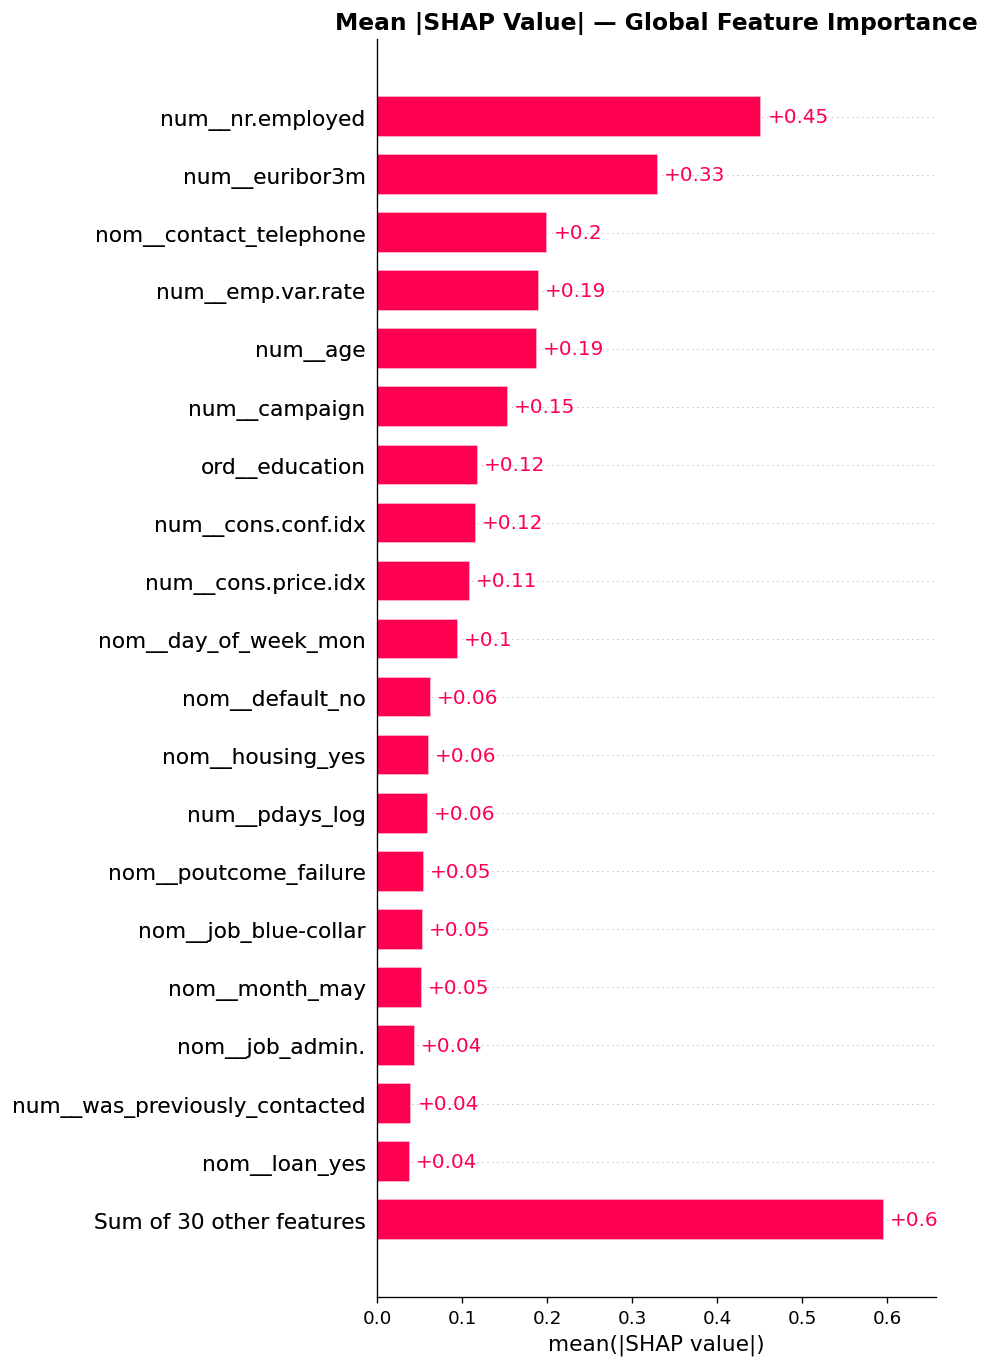


📊 TOP 15 FEATURES BY MEAN |SHAP|:
   1. num__nr.employed                         0.4521
   2. num__euribor3m                           0.3300
   3. nom__contact_telephone                   0.2002
   4. num__emp.var.rate                        0.1900
   5. num__age                                 0.1877
   6. num__campaign                            0.1542
   7. ord__education                           0.1188
   8. num__cons.conf.idx                       0.1159
   9. num__cons.price.idx                      0.1095
  10. nom__day_of_week_mon                     0.0951
  11. nom__default_no                          0.0633
  12. nom__housing_yes                         0.0603
  13. num__pdays_log                           0.0601
  14. nom__poutcome_failure                    0.0549
  15. nom__job_blue-collar                     0.0542


In [6]:
# === CELL 6: SHAP Bar Plot (Mean Absolute Importance) ===
fig, ax = plt.subplots(figsize=(10, 8))
shap.plots.bar(shap_to_plot, max_display=20, show=False)
plt.title("Mean |SHAP Value| — Global Feature Importance", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "shap_bar.png", bbox_inches="tight", dpi=150)
plt.show()

# Extract top features
if len(shap_values.shape) == 3:
    mean_abs_shap = np.abs(shap_values.values[:, :, 1]).mean(axis=0)
else:
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

top_features = sorted(
    zip(feature_names, mean_abs_shap),
    key=lambda x: x[1], reverse=True
)

print("\n📊 TOP 15 FEATURES BY MEAN |SHAP|:")
for rank, (feat, imp) in enumerate(top_features[:15], 1):
    print(f"  {rank:2d}. {feat:40s} {imp:.4f}")

SHAP DEPENDENCE PLOTS — How feature values affect predictions


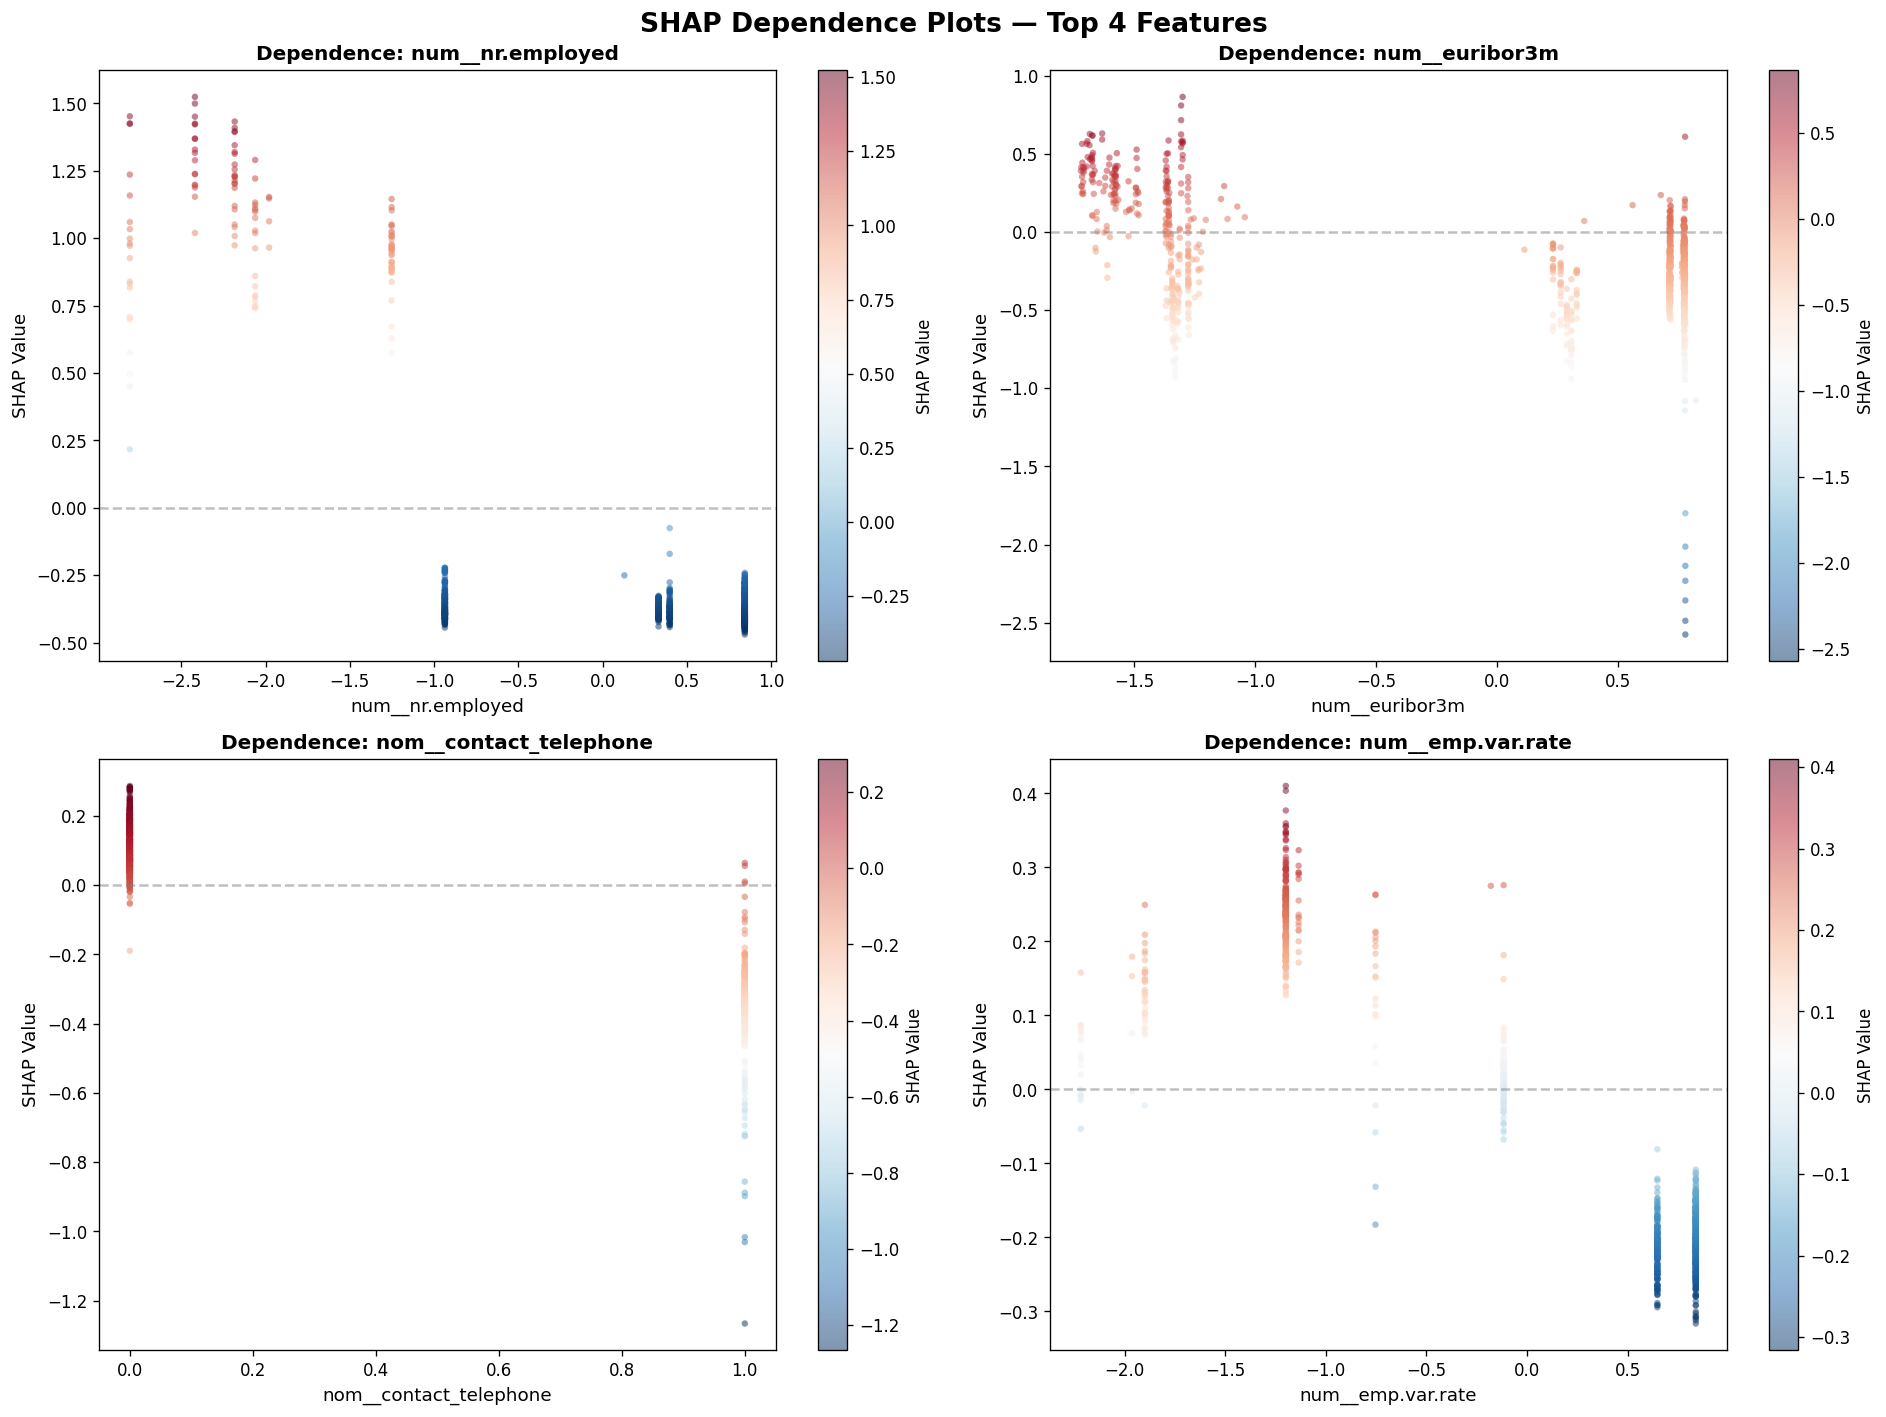

In [7]:
# === CELL 7: SHAP Dependence Plots — Top Features ===
print("=" * 60)
print("SHAP DEPENDENCE PLOTS — How feature values affect predictions")
print("=" * 60)

top_4_names = [f for f, _ in top_features[:4]]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, feat_name in enumerate(top_4_names):
    feat_idx = feature_names.index(feat_name)
    ax = axes[i]

    if len(shap_values.shape) == 3:
        shap_vals = shap_values.values[:, feat_idx, 1]
    else:
        shap_vals = shap_values.values[:, feat_idx]

    feat_vals = X_sample[feat_name].values

    scatter = ax.scatter(feat_vals, shap_vals, c=shap_vals, cmap="RdBu_r",
                         alpha=0.5, s=15, edgecolors="none")
    ax.set_xlabel(feat_name, fontsize=11)
    ax.set_ylabel("SHAP Value", fontsize=11)
    ax.set_title(f"Dependence: {feat_name}", fontsize=12, fontweight="bold")
    ax.axhline(0, color="gray", linestyle="--", alpha=0.5)
    plt.colorbar(scatter, ax=ax, label="SHAP Value")

plt.suptitle("SHAP Dependence Plots — Top 4 Features", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "shap_dependence.png", bbox_inches="tight", dpi=150)
plt.show()

LOCAL EXPLANATIONS — Individual Predictions

 High Confidence POSITIVE
 Predicted probability: 0.9891
 Actual label: Subscribe


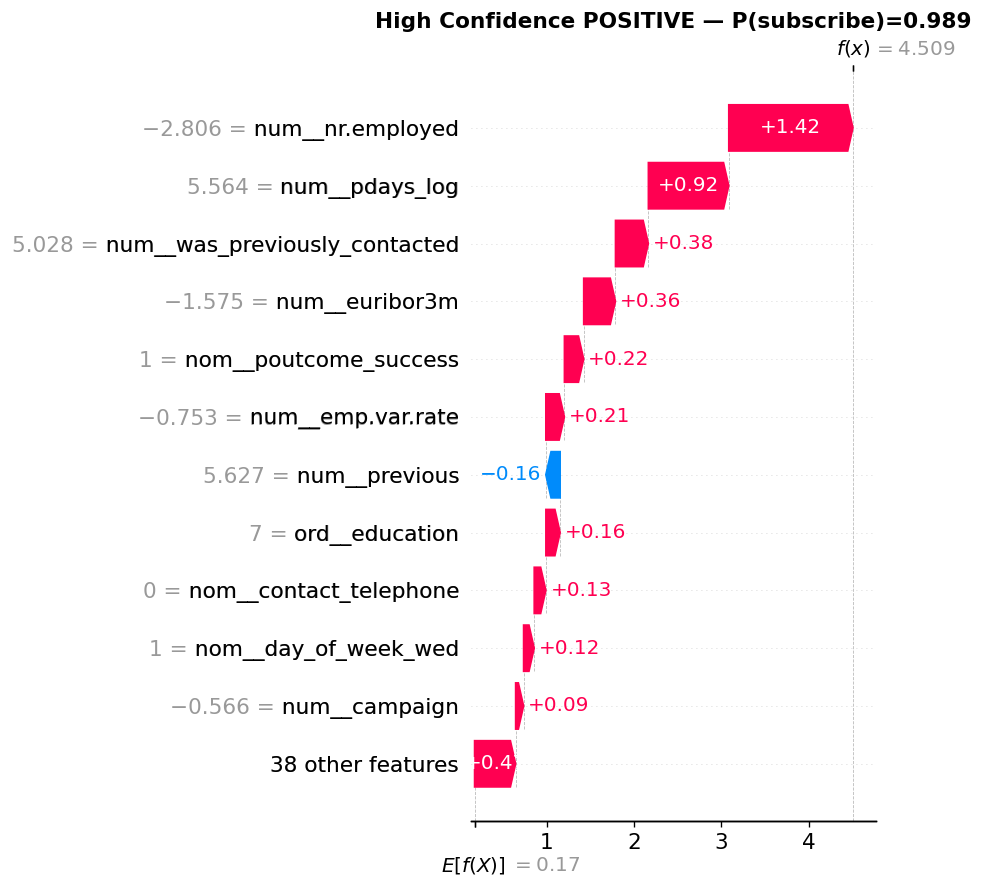


 High Confidence NEGATIVE
 Predicted probability: 0.0096
 Actual label: No Subscribe


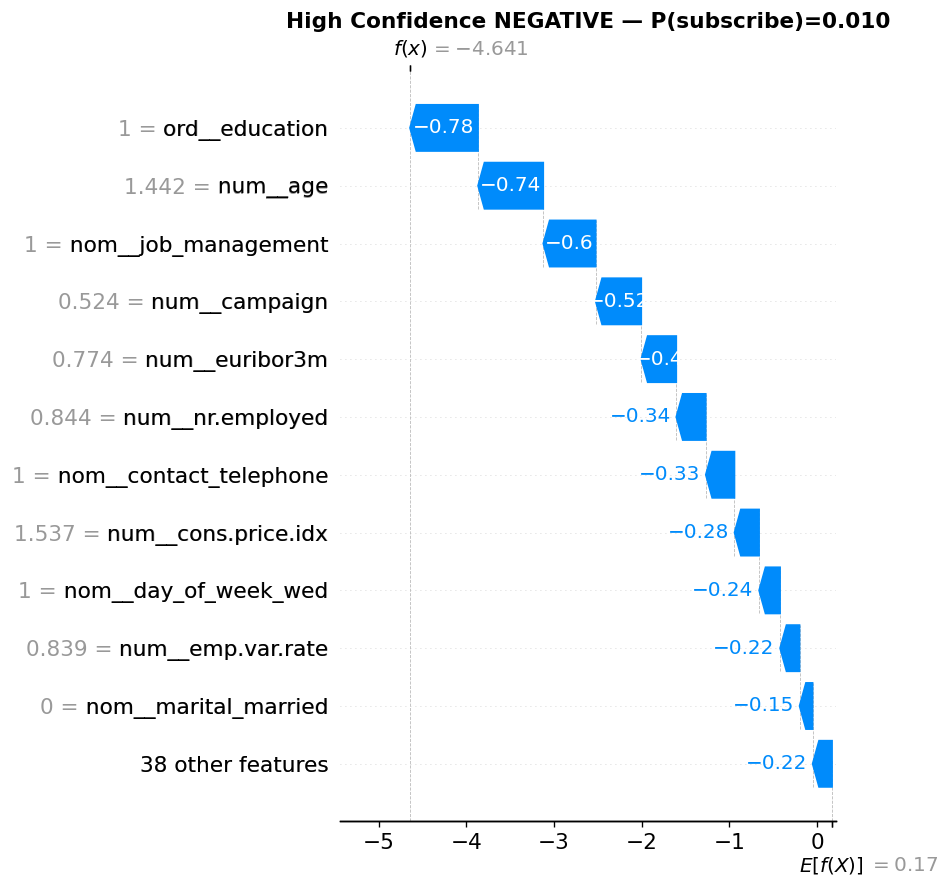


 Edge Case (near threshold)
 Predicted probability: 0.3001
 Actual label: No Subscribe


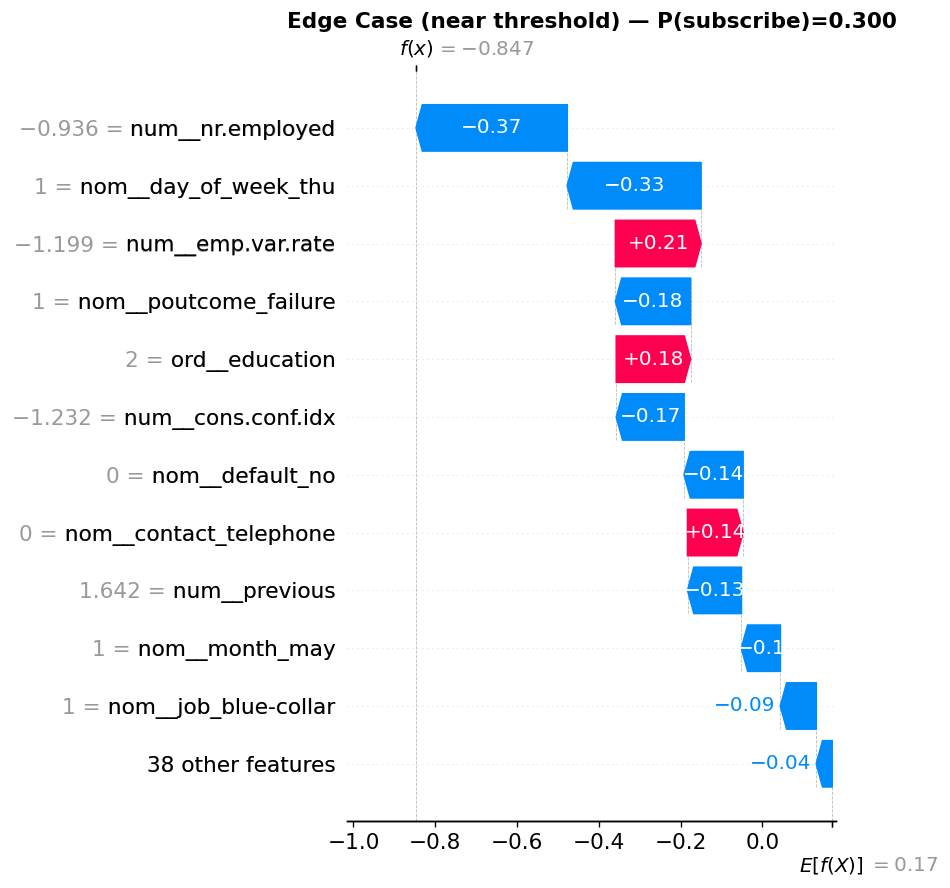

In [8]:
# === CELL 8: Local Explanations — Individual Predictions ===
print("=" * 60)
print("LOCAL EXPLANATIONS — Individual Predictions")
print("=" * 60)

# Find interesting cases: high-confidence positive, high-confidence negative, edge case
probs = classifier.predict_proba(X_test_transformed[:SAMPLE_SIZE])[:, 1]

# High confidence positive
high_pos_idx = np.argmax(probs)
# High confidence negative
high_neg_idx = np.argmin(probs)
# Edge case (closest to threshold 0.30)
edge_idx = np.argmin(np.abs(probs - 0.30))

cases = {
    "High Confidence POSITIVE": high_pos_idx,
    "High Confidence NEGATIVE": high_neg_idx,
    "Edge Case (near threshold)": edge_idx,
}

for case_name, idx in cases.items():
    print(f"\n{'='*50}")
    print(f" {case_name}")
    print(f" Predicted probability: {probs[idx]:.4f}")
    print(f" Actual label: {'Subscribe' if y_sample.iloc[idx] == 1 else 'No Subscribe'}")
    print(f"{'='*50}")

    fig, ax = plt.subplots(figsize=(14, 4))

    if len(shap_values.shape) == 3:
        sv = shap_to_plot[idx]
    else:
        sv = shap_values[idx]

    shap.plots.waterfall(sv, max_display=12, show=False)
    plt.title(f"{case_name} — P(subscribe)={probs[idx]:.3f}", fontsize=13, fontweight="bold")
    plt.tight_layout()

    safe_name = case_name.lower().replace(" ", "_").replace("(", "").replace(")", "")
    plt.savefig(FIGURES_DIR / f"shap_waterfall_{safe_name}.png", bbox_inches="tight", dpi=150)
    plt.show()

FORCE PLOT — Visual explanation of a single prediction


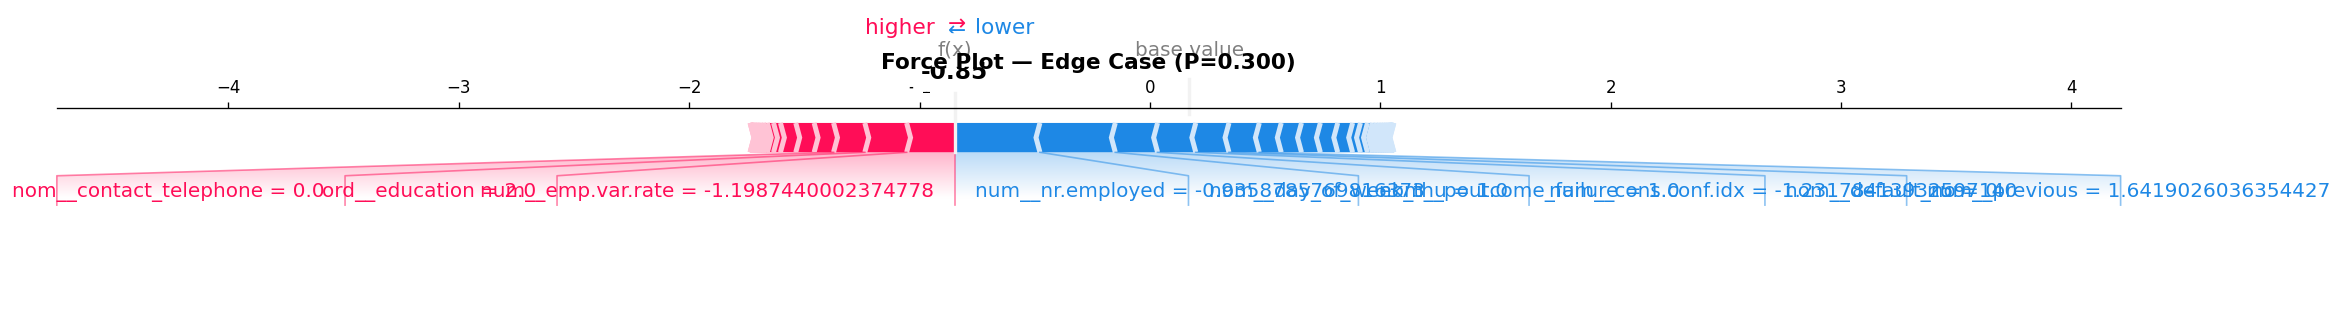

In [9]:
# === CELL 9: SHAP Force Plot — Single Prediction ===
print("=" * 60)
print("FORCE PLOT — Visual explanation of a single prediction")
print("=" * 60)

# Show force plot for the edge case
idx = edge_idx

if len(shap_values.shape) == 3:
    expected = explainer.expected_value[1]
    sv_single = shap_values.values[idx, :, 1]
else:
    expected = explainer.expected_value
    sv_single = shap_values.values[idx]

shap.initjs()
force_plot = shap.force_plot(
    expected,
    sv_single,
    X_sample.iloc[idx],
    feature_names=feature_names,
    matplotlib=True,
    show=False,
)
plt.title(f"Force Plot — Edge Case (P={probs[idx]:.3f})", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "shap_force_plot.png", bbox_inches="tight", dpi=150)
plt.show()

SHAP INTERACTION — Do features work together?
Computing interaction values for 200 samples...

Top 10 Feature Interactions:
  num__age                            ↔ num__euribor3m                     : 0.0603
  num__age                            ↔ ord__education                     : 0.0415
  num__campaign                       ↔ num__euribor3m                     : 0.0384
  num__euribor3m                      ↔ nom__contact_telephone             : 0.0381
  num__age                            ↔ num__campaign                      : 0.0343


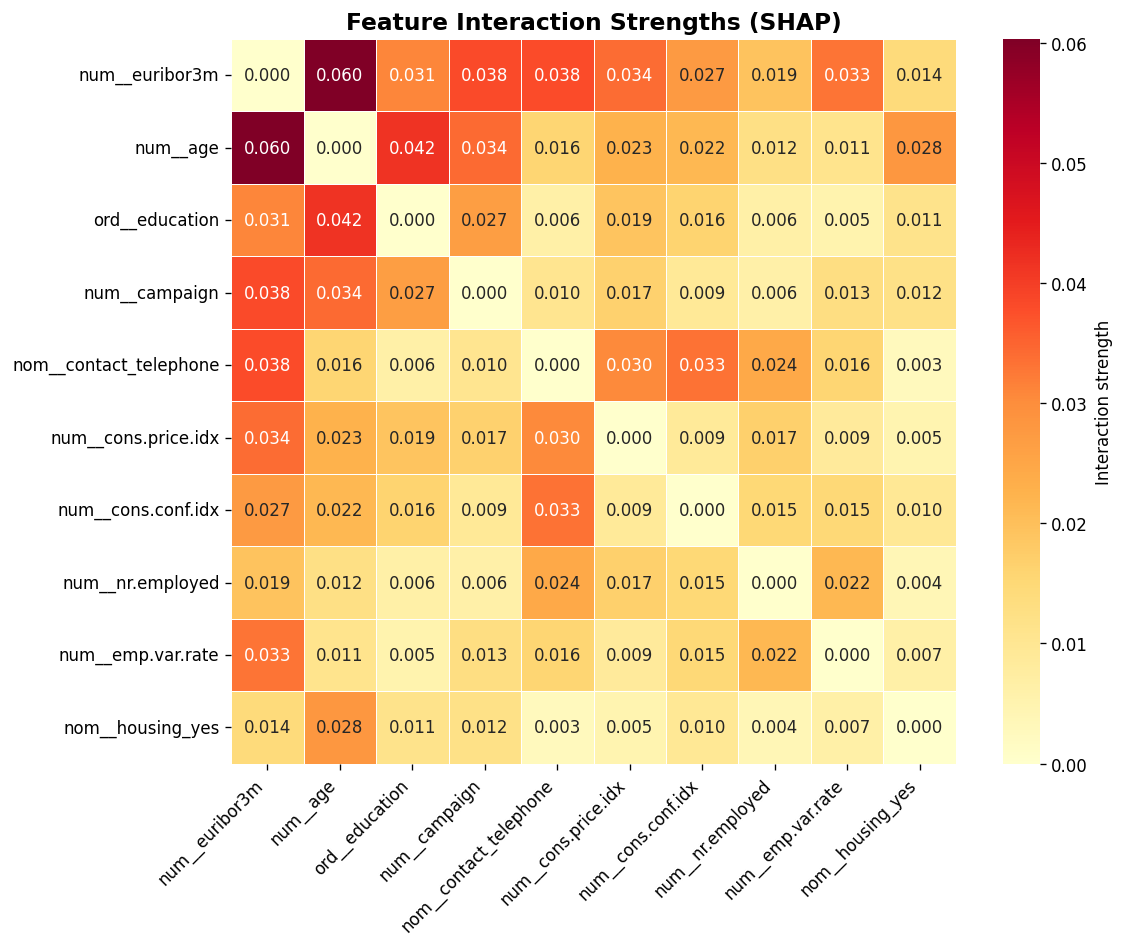

In [13]:
# === CELL 10: SHAP Interaction Effects ===
print("=" * 60)
print("SHAP INTERACTION — Do features work together?")
print("=" * 60)

# Compute interaction values (slower, use smaller sample)
INTERACTION_SAMPLE = min(200, SAMPLE_SIZE)
X_interact = X_sample.iloc[:INTERACTION_SAMPLE]

print(f"Computing interaction values for {INTERACTION_SAMPLE} samples...")
shap_interaction = explainer.shap_interaction_values(X_interact)

# For binary classification, take positive class
if isinstance(shap_interaction, list):
    shap_interaction = shap_interaction[1]

# Find top interactions
n_features = shap_interaction.shape[1]
interaction_matrix = np.abs(shap_interaction).mean(axis=0)
np.fill_diagonal(interaction_matrix, 0)  # Remove self-interactions

# Get top 10 interactions
flat_idx = np.argsort(interaction_matrix.ravel())[::-1][:10]
rows, cols = np.unravel_index(flat_idx, interaction_matrix.shape)

print("\nTop 10 Feature Interactions:")
for r, c in zip(rows, cols):
    if r < c:  # Avoid duplicates
        print(f"  {feature_names[r]:35s} ↔ {feature_names[c]:35s}: {interaction_matrix[r, c]:.4f}")

# Heatmap of top feature interactions (select by total interaction strength per feature)
top_n = 10
interaction_strength = interaction_matrix.sum(axis=1)
top_idx = np.argsort(interaction_strength)[::-1][:top_n]
sub_matrix = np.asarray(interaction_matrix[np.ix_(top_idx, top_idx)], dtype=float)
sub_names = [feature_names[i][:25] for i in top_idx]

fig, ax = plt.subplots(figsize=(10, 8))
vmax = sub_matrix.max() if sub_matrix.size > 0 and sub_matrix.max() > 0 else 1.0
sns.heatmap(sub_matrix, xticklabels=sub_names, yticklabels=sub_names,
            cmap="YlOrRd", annot=True, fmt=".3f", ax=ax, linewidths=0.5,
            vmin=0, vmax=vmax, square=True, cbar_kws={"label": "Interaction strength"})
ax.set_title("Feature Interaction Strengths (SHAP)", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "shap_interactions.png", bbox_inches="tight", dpi=150)
plt.show()

📋 BUSINESS-READY FEATURE IMPORTANCE REPORT


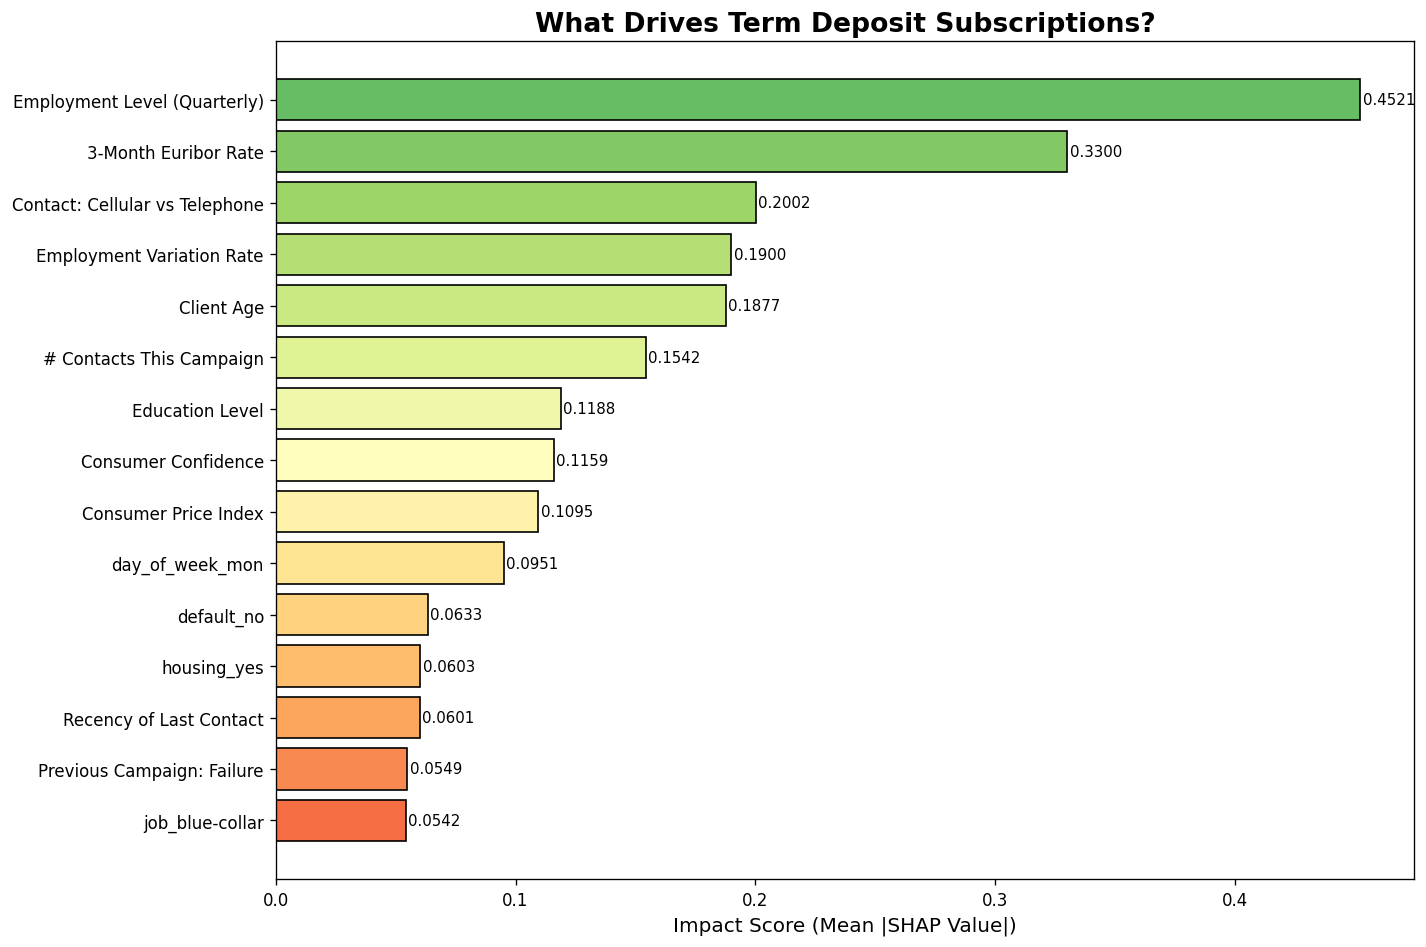

                       Feature         Technical Name  Importance Score
  Employment Level (Quarterly)       num__nr.employed            0.4521
          3-Month Euribor Rate         num__euribor3m            0.3300
Contact: Cellular vs Telephone nom__contact_telephone            0.2002
     Employment Variation Rate      num__emp.var.rate            0.1900
                    Client Age               num__age            0.1877
      # Contacts This Campaign          num__campaign            0.1542
               Education Level         ord__education            0.1188
           Consumer Confidence     num__cons.conf.idx            0.1159
          Consumer Price Index    num__cons.price.idx            0.1095
               day_of_week_mon   nom__day_of_week_mon            0.0951
                    default_no        nom__default_no            0.0633
                   housing_yes       nom__housing_yes            0.0603
       Recency of Last Contact         num__pdays_log           

In [14]:
# === CELL 11: Business-Ready Feature Importance Report ===
import seaborn as sns

print("=" * 60)
print("📋 BUSINESS-READY FEATURE IMPORTANCE REPORT")
print("=" * 60)

# Clean feature names for business audience
def clean_feature_name(name: str) -> str:
    """Make feature names readable for non-technical stakeholders."""
    replacements = {
        "num__euribor3m": "3-Month Euribor Rate",
        "num__nr.employed": "Employment Level (Quarterly)",
        "num__emp.var.rate": "Employment Variation Rate",
        "num__age": "Client Age",
        "num__cons.conf.idx": "Consumer Confidence",
        "num__cons.price.idx": "Consumer Price Index",
        "num__campaign": "# Contacts This Campaign",
        "num__previous": "# Previous Contacts",
        "num__was_previously_contacted": "Was Previously Contacted",
        "num__pdays_log": "Recency of Last Contact",
        "nom__poutcome_success": "Previous Campaign: Success",
        "nom__poutcome_failure": "Previous Campaign: Failure",
        "nom__contact": "Contact: Cellular vs Telephone",
        "nom__month_mar": "Month: March",
        "nom__month_oct": "Month: October",
        "nom__month_may": "Month: May",
        "ord__education": "Education Level",
    }
    for key, val in replacements.items():
        if key in name:
            return val
    return name.replace("num__", "").replace("nom__", "").replace("ord__", "")

business_importance = pd.DataFrame({
    "Feature": [clean_feature_name(f) for f, _ in top_features[:15]],
    "Technical Name": [f for f, _ in top_features[:15]],
    "Importance Score": [round(imp, 4) for _, imp in top_features[:15]],
})

fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(business_importance)))
ax.barh(business_importance["Feature"], business_importance["Importance Score"],
        color=colors, edgecolor="black")
ax.set_xlabel("Impact Score (Mean |SHAP Value|)", fontsize=12)
ax.set_title("What Drives Term Deposit Subscriptions?",
             fontsize=16, fontweight="bold")
ax.invert_yaxis()

# Add importance annotations
for i, (feat, score) in enumerate(zip(business_importance["Feature"],
                                       business_importance["Importance Score"])):
    ax.text(score + 0.001, i, f"{score:.4f}", va="center", fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "business_feature_importance.png", bbox_inches="tight", dpi=150)
plt.show()

print(business_importance.to_string(index=False))

print("""
📋 ACTIONABLE INSIGHTS FOR MARKETING TEAM:

1. MACRO-ECONOMIC TIMING IS CRITICAL
   • Lower Euribor rates → higher conversion. Time campaigns during rate drops.
   • Employment level signals economic confidence — campaign in strong economy.

2. LEVERAGE PREVIOUS SUCCESSES
   • Clients who subscribed before are 8x more likely to convert again.
   • Build a "win-back" list from previous successful campaigns.

3. OPTIMIZE CONTACT STRATEGY
   • Use cellular over telephone (significantly higher conversion).
   • Diminishing returns after 3 contacts — stop calling after that.
   • Best months: March, September, October (avoid May — high volume, low conversion).

4. TARGET HIGH-VALUE SEGMENTS
   • Retirees and students show highest conversion rates.
   • Older clients (55+) are more receptive to term deposits.
   • Higher education correlates with higher conversion.

5. RECENCY MATTERS
   • Recent previous contact (within 3 days) has highest conversion.
   • Long gaps between contacts reduce conversion probability.
""")

In [16]:
# === CELL 12: Save SHAP Data for Dashboard ===
import json

shap_export = {
    "top_features": [
        {"name": clean_feature_name(f), "technical_name": f, "importance": round(float(imp), 4)}
        for f, imp in top_features[:20]
    ],
    "sample_size": SAMPLE_SIZE,
    "model": "XGBoost",
}

with open(FIGURES_DIR.parent / "metrics" / "shap_importance.json", "w") as f:
    json.dump(shap_export, f, indent=2)

print("✅ SHAP data exported for Streamlit dashboard")
print(f"\nFigures saved to: {FIGURES_DIR}")
print("  • shap_summary.png")
print("  • shap_bar.png")
print("  • shap_dependence.png")
print("  • shap_waterfall_*.png")
print("  • shap_force_plot.png")
print("  • shap_interactions.png")
print("  • business_feature_importance.png")

✅ SHAP data exported for Streamlit dashboard

Figures saved to: c:\Users\ashranj\GIT\DSI\DSI-Cohort8-ML-2\reports\figures
  • shap_summary.png
  • shap_bar.png
  • shap_dependence.png
  • shap_waterfall_*.png
  • shap_force_plot.png
  • shap_interactions.png
  • business_feature_importance.png
